<p style="font-size:200%;font-weight:bold">资产定价101</p>

- 作者：丁文治
- 日期：2022年2月26日

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', 500)

%matplotlib inline

RD = "/home/team_crypto/2022_crypto_return/02_rdata/"
WD = "/home/team_crypto/2022_crypto_return/03_wdata/"

# 读入数据

## 价格

In [2]:
prc = pd.read_parquet(f'{RD}ASHAREEODPRICES.pq')
prc.shape
prc.sample(3)

,OBJECT_ID,S_INFO_WINDCODE,TRADE_DT,CRNCY_CODE,S_DQ_PRECLOSE,S_DQ_OPEN,S_DQ_HIGH,S_DQ_LOW,S_DQ_CLOSE,S_DQ_CHANGE,S_DQ_PCTCHANGE,S_DQ_VOLUME,S_DQ_AMOUNT,S_DQ_ADJPRECLOSE,S_DQ_ADJOPEN,S_DQ_ADJHIGH,S_DQ_ADJLOW,S_DQ_ADJCLOSE,S_DQ_ADJFACTOR,S_DQ_AVGPRICE,S_DQ_TRADESTATUS,S_DQ_TRADESTATUSCODE,OPDATE,OPMODE
3510511,{51E41DC3-108C-11E8-BE0D-4CCC6AE9D276},600362.SH,20180213,CNY,17.73,17.97,18.33,17.82,18.09,0.36,2.0305,539892.46,975150.6690,27.62,27.99,28.55,27.76,28.18,1.557591,18.0619,交易,-1.0,2018-02-13 15:06:32,0
1506572,{E530E3DE-9810-4CDE-8B91-F81C4ED8D72D},002714.SZ,20150619,CNY,45.16,43.43,47.00,43.04,44.83,-0.33,-0.7307,33322.97,151560.9083,90.87,87.39,94.57,86.60,90.20,2.012125,45.4824,交易,-1.0,2015-06-19 15:08:07,0
545334,{37B56061-DB28-4C28-B831-61F56C5D411E},600673.SH,20040914,CNY,5.73,5.80,5.98,5.80,5.95,0.22,3.8394,2234.92,1324.2760,10.48,10.61,10.94,10.61,10.88,1.829018,5.9254,交易,-1.0,2004-09-14 15:16:06,0


In [3]:
prc['TRADE_DT']
prc['TRADE_DT'] = pd.to_datetime(prc['TRADE_DT'])
prc['TRADE_DT'].describe(datetime_is_numeric=True)

count                         12711196
mean     2012-10-09 05:59:53.134868480
min                1990-12-19 00:00:00
25%                2007-12-03 00:00:00
50%                2014-05-26 00:00:00
75%                2018-09-06 00:00:00
max                2021-12-16 00:00:00
Name: TRADE_DT, dtype: object

In [4]:
prc['CRNCY_CODE'].value_counts()

CNY    12711196
Name: CRNCY_CODE, dtype: int64

In [5]:
# 取最近三年数据
prc = prc.loc[
    (prc['TRADE_DT'] >= "2018-01-01")
    & (prc['S_INFO_WINDCODE'].str.contains('SZ|SH'))
    , 
    [
        "S_INFO_WINDCODE",  # 股票代码
        "TRADE_DT",         # 交易日期
        "S_DQ_ADJCLOSE",   # 收盘价
        
    ]
]
prc.shape
prc.sample(3)

(3702810, 3)

,S_INFO_WINDCODE,TRADE_DT,S_DQ_ADJCLOSE
6407900,300195.SZ,2021-04-06,17.66
4102060,002708.SZ,2018-10-24,12.72
5752616,002158.SZ,2020-08-11,53.51


In [6]:
# 保留月末数据
prc['ym'] = prc['TRADE_DT'].dt.year * 100 + prc['TRADE_DT'].dt.month
prc.sample()

,S_INFO_WINDCODE,TRADE_DT,S_DQ_ADJCLOSE,ym
3537618,002578.SZ,2018-03-02,21.99,201803


In [7]:
prc.sort_values(['S_INFO_WINDCODE', 'TRADE_DT'], ascending=True, inplace=True)
prc.drop_duplicates(subset=['S_INFO_WINDCODE', 'ym'], keep='last', inplace=True)
prc.shape
prc.sample(3)

(185692, 4)

,S_INFO_WINDCODE,TRADE_DT,S_DQ_ADJCLOSE,ym
4707770,601002.SH,2019-06-28,7.67,201906
4199983,002664.SZ,2018-11-30,36.75,201811
6757381,600851.SH,2021-07-30,105.94,202107


## 市值

In [8]:
mv = pd.read_parquet(f'{RD}ASHAREEODDERIVATIVEINDICATOR.pq', columns=['S_INFO_WINDCODE', 'TRADE_DT', 'S_DQ_MV', 'S_VAL_PB_NEW'])
mv['TRADE_DT'] = pd.to_datetime(mv['TRADE_DT'])
mv.shape
mv.sample(3)

(19122875, 4)

,S_INFO_WINDCODE,TRADE_DT,S_DQ_MV,S_VAL_PB_NEW
469039,600250.SH,2003-05-17,82500.0000,2.9411
3763902,000553.SZ,2015-12-28,389363.5359,3.0229
5640835,000552.SZ,2017-08-30,624532.9291,1.3783


## 合并

In [9]:
df = prc.merge(mv, on=['S_INFO_WINDCODE', 'TRADE_DT'], how='left', validate='1:1', indicator=True)
df['_merge'].value_counts()
df.sample(3)

both          185691
left_only          1
right_only         0
Name: _merge, dtype: int64

,S_INFO_WINDCODE,TRADE_DT,S_DQ_ADJCLOSE,ym,S_DQ_MV,S_VAL_PB_NEW,_merge
81643,300293.SZ,2018-02-28,45.26,201802,255203.1901,3.4972,both
38570,002347.SZ,2019-10-31,16.60,201910,140014.5434,1.7233,both
103399,300766.SZ,2021-01-29,15.85,202101,489633.9580,3.6077,both


In [10]:
df = df.loc[df['_merge'] == 'both']
df.drop(columns=['_merge', 'TRADE_DT'], inplace=True)
df.sample(3)

,S_INFO_WINDCODE,S_DQ_ADJCLOSE,ym,S_DQ_MV,S_VAL_PB_NEW
124673,600433.SH,23.94,201906,4.780146e+05,1.8313
129195,600558.SH,23.59,202111,2.989024e+05,1.3919
118625,600276.SH,2927.59,201906,2.906584e+07,14.2947


In [11]:
df.columns = ['stkcd', 'prc', 'ym', 'mv', 'pb']
df.sample(3)

,stkcd,prc,ym,mv,pb
9184,000619.SZ,50.76,201908,198720.0000,0.8098
123798,600403.SH,19.55,201810,903727.0880,1.1941
148213,601127.SH,17.77,201806,311242.2177,3.3434


In [12]:
df.sort_values(['stkcd', 'ym'], ascending=True, inplace=True)
df['ret'] = df.groupby(['stkcd'])['prc'].pct_change()
df['ret_l1'] = df.groupby(['stkcd'])['ret'].shift()
df['ret_l12_l2'] = df.groupby(['stkcd'])['prc'].shift(12) / df.groupby(['stkcd'])['prc'].shift(2) - 1
df['mv_l1'] = df.groupby(['stkcd'])['mv'].shift()
df['pb_l1'] = df.groupby(['stkcd'])['pb'].shift()
# df.drop(columns=['prc'], inplace=True)
df.head()

,stkcd,prc,ym,mv,pb,ret,ret_l1,ret_l12_l2,mv_l1,pb_l1
0,000001.SZ,1493.64,201801,2.376978e+07,1.2174,NaN,NaN,NaN,NaN,NaN
1,000001.SZ,1281.02,201802,2.038618e+07,1.0441,-0.142350,NaN,NaN,2.376978e+07,1.2174
2,000001.SZ,1158.77,201803,1.844060e+07,0.9261,-0.095432,-0.142350,NaN,2.038618e+07,1.0441
3,000001.SZ,1153.45,201804,1.835601e+07,0.9158,-0.004591,-0.095432,NaN,1.844060e+07,0.9261
4,000001.SZ,1082.22,201805,1.747931e+07,0.8592,-0.061754,-0.004591,NaN,1.835601e+07,0.9158


In [13]:
df.to_parquet(f'{WD}0001_teaching/0100_return.pq')

# 计算因子

In [14]:
df = pd.read_parquet(f'{WD}0001_teaching/0100_return.pq')
df.shape
df.sample(3)

(185691, 10)

,stkcd,prc,ym,mv,pb,ret,ret_l1,ret_l12_l2,mv_l1,pb_l1
75500,300163.SZ,23.12,201910,124386.7505,3.0530,0.033989,-0.088091,-0.202284,120286.0884,3.0906
65855,002940.SZ,43.43,202003,200718.0000,3.9614,0.113590,0.089994,0.160704,180258.7500,3.5576
169108,603608.SH,9.17,202108,246630.6991,1.5591,0.033822,-0.149569,0.345158,238481.1630,1.5241


In [15]:
df['retw'] = df['ret']
df.loc[df['ret'] <= df['ret'].quantile(0.01), 'retw'] = df['ret'].quantile(0.01)
df.loc[df['ret'] >= df['ret'].quantile(0.99), 'retw'] = df['ret'].quantile(0.99)

,ret,retw
count,181061.000000,181061.000000
mean,0.009081,0.007343
std,0.141656,0.123758
min,-0.863659,-0.258092
25%,-0.069743,-0.069743
50%,-0.007089,-0.007089
75%,0.063953,0.063953
max,4.563492,0.461865


array([[<AxesSubplot:title={'center':'ret'}>,
        <AxesSubplot:title={'center':'retw'}>]], dtype=object)

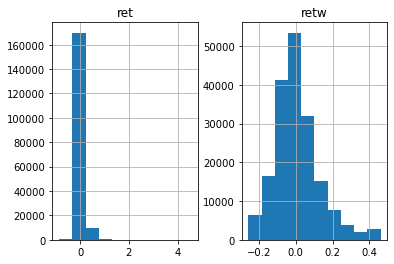

In [16]:
df[['ret', 'retw']].describe()
df[['ret', 'retw']].hist()

<AxesSubplot:>

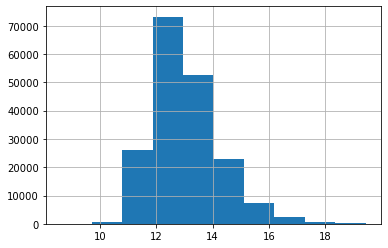

In [17]:
df['mv'].apply(lambda x: np.log(x)).hist()  # 接近标准log-normal分布

## 市场回报率

In [18]:
mret = df.copy()
mret['retw'] *= mret['mv_l1']
mret['cnt'] = 1
mret = mret.groupby(['ym'], as_index=False)[['retw', 'mv_l1', 'cnt']].sum()
mret['mret'] = mret['retw'] / mret['mv_l1']
mret.drop(columns=['mv_l1', 'retw'], inplace=True)
mret.head(10)

,ym,cnt,mret
0,201801,3477,NaN
1,201802,3489,-0.054280
2,201803,3499,-0.014240
3,201804,3508,-0.031775
4,201805,3518,0.001921
5,201806,3525,-0.073889
6,201807,3532,0.012499
7,201808,3536,-0.054785
8,201809,3547,0.025797
9,201810,3552,-0.083249


In [19]:
mret['mret'].describe()

count    47.000000
mean      0.005555
std       0.046171
min      -0.083249
25%      -0.014905
50%       0.002694
75%       0.025986
max       0.151480
Name: mret, dtype: float64

In [20]:
mret.loc[mret['mret'] < -0.05]  # 新冠

,ym,cnt,mret
1,201802,3489,-0.054280
5,201806,3525,-0.073889
7,201808,3536,-0.054785
9,201810,3552,-0.083249
16,201905,3621,-0.059273
26,202003,3800,-0.054992
32,202009,4027,-0.055861


<AxesSubplot:>

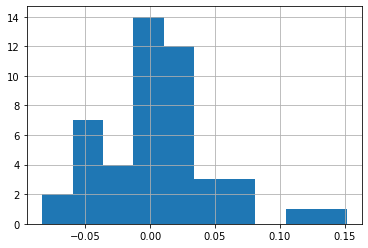

In [21]:
mret['mret'].hist()

## SMB & HML

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_factors.html

In [22]:
df['size_rank'] = df.groupby(['ym'])['mv_l1'].rank(pct=True)
df['pb_rank'] = df.groupby(['ym'])['pb_l1'].rank(pct=True)
df.head()

,stkcd,prc,ym,mv,pb,ret,ret_l1,ret_l12_l2,mv_l1,pb_l1,retw,size_rank,pb_rank
0,000001.SZ,1493.64,201801,2.376978e+07,1.2174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000001.SZ,1281.02,201802,2.038618e+07,1.0441,-0.142350,NaN,NaN,2.376978e+07,1.2174,-0.142350,0.993385,0.035488
2,000001.SZ,1158.77,201803,1.844060e+07,0.9261,-0.095432,-0.142350,NaN,2.038618e+07,1.0441,-0.095432,0.992548,0.020678
3,000001.SZ,1153.45,201804,1.835601e+07,0.9158,-0.004591,-0.095432,NaN,1.844060e+07,0.9261,-0.004591,0.992569,0.011451
4,000001.SZ,1082.22,201805,1.747931e+07,0.8592,-0.061754,-0.004591,NaN,1.835601e+07,0.9158,-0.061754,0.992018,0.013154


In [23]:
df['sl'] = (df['size_rank'] <= 0.5) & (df['pb_rank'] < 0.3)
df['sn'] = (df['size_rank'] <= 0.5) & (df['pb_rank'].between(0.3, 0.7))
df['sh'] = (df['size_rank'] <= 0.5) & (df['pb_rank'] > 0.7)
df['bl'] = (df['size_rank'] > 0.5) & (df['pb_rank'] < 0.3)
df['bn'] = (df['size_rank'] > 0.5) & (df['pb_rank'].between(0.3, 0.7))
df['bh'] = (df['size_rank'] > 0.5) & (df['pb_rank'] > 0.7)

In [24]:
rets = []
for p in ['sl', 'sn', 'sh', 'bl', 'bn', 'bh']:
    t = df[df[p]].copy()
    t['retw'] *= t['mv_l1']
    t = t.groupby(['ym'])[['retw', 'mv_l1']].sum()
    t['retw'] /= t['mv_l1']
    t.drop(columns=['mv_l1'], inplace=True)
    t.columns = [p]
    rets.append(t)
ret = pd.concat(rets, axis=1)
ret.shape
ret.head(3)

(47, 6)

,sl,sn,sh,bl,bn,bh
ym,,,,,,
201802,-0.054748,-0.053591,-0.053247,-0.073155,-0.047822,-0.020426
201803,0.046115,0.066899,0.081976,-0.040564,-0.012172,0.007749
201804,-0.048477,-0.035306,-0.043881,-0.021370,-0.045697,-0.033642


In [25]:
ret['smb'] = (ret['sl'] + ret['sn'] + ret['sh']) / 3 - (ret['bl'] + ret['bn'] + ret['bh']) / 3
ret['hml'] = (ret['sh'] + ret['bh']) / 2 - (ret['sl'] + ret['bl']) / 2
ret.head(3)

,sl,sn,sh,bl,bn,bh,smb,hml
ym,,,,,,,,
201802,-0.054748,-0.053591,-0.053247,-0.073155,-0.047822,-0.020426,-0.006727,0.027115
201803,0.046115,0.066899,0.081976,-0.040564,-0.012172,0.007749,0.079992,0.042087
201804,-0.048477,-0.035306,-0.043881,-0.021370,-0.045697,-0.033642,-0.008985,-0.003838


In [26]:
tf = ret.loc[:, ['smb', 'hml']].reset_index()
tf.head(3)

,ym,smb,hml
0,201802,-0.006727,0.027115
1,201803,0.079992,0.042087
2,201804,-0.008985,-0.003838


## Momentum

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library/det_mom_factor.html

In [27]:
df['ret_rank'] = df.groupby(['ym'])['ret_l12_l2'].rank(pct=True)
df.head()

,stkcd,prc,ym,mv,pb,ret,ret_l1,ret_l12_l2,mv_l1,pb_l1,retw,size_rank,pb_rank,sl,sn,sh,bl,bn,bh,ret_rank
0,000001.SZ,1493.64,201801,2.376978e+07,1.2174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,NaN
1,000001.SZ,1281.02,201802,2.038618e+07,1.0441,-0.142350,NaN,NaN,2.376978e+07,1.2174,-0.142350,0.993385,0.035488,False,False,False,True,False,False,NaN
2,000001.SZ,1158.77,201803,1.844060e+07,0.9261,-0.095432,-0.142350,NaN,2.038618e+07,1.0441,-0.095432,0.992548,0.020678,False,False,False,True,False,False,NaN
3,000001.SZ,1153.45,201804,1.835601e+07,0.9158,-0.004591,-0.095432,NaN,1.844060e+07,0.9261,-0.004591,0.992569,0.011451,False,False,False,True,False,False,NaN
4,000001.SZ,1082.22,201805,1.747931e+07,0.8592,-0.061754,-0.004591,NaN,1.835601e+07,0.9158,-0.061754,0.992018,0.013154,False,False,False,True,False,False,NaN


In [28]:
df['sl'] = (df['size_rank'] <= 0.5) & (df['ret_rank'] < 0.3)
df['sh'] = (df['size_rank'] <= 0.5) & (df['ret_rank'] > 0.7)
df['bl'] = (df['size_rank'] > 0.5) & (df['ret_rank'] < 0.3)
df['bh'] = (df['size_rank'] > 0.5) & (df['ret_rank'] > 0.7)

In [29]:
rets = []
for p in ['sl', 'sh', 'bl', 'bh']:
    t = df[df[p]].copy()
    t['retw'] *= t['mv_l1']
    t = t.groupby(['ym'])[['retw', 'mv_l1']].sum()
    t['retw'] /= t['mv_l1']
    t.drop(columns=['mv_l1'], inplace=True)
    t.columns = [p]
    rets.append(t)
ret = pd.concat(rets, axis=1)
ret.shape
ret.head(3)

(36, 4)

,sl,sh,bl,bh
ym,,,,
201901,-0.028522,-0.055354,0.037553,0.001518
201902,0.209991,0.265077,0.099570,0.255549
201903,0.111172,0.101486,0.049915,0.068997


In [30]:
ret['mom'] = (ret['sh'] + ret['bh']) / 2 - (ret['sl'] + ret['bl']) / 2
ret.head(3)

,sl,sh,bl,bh,mom
ym,,,,,
201901,-0.028522,-0.055354,0.037553,0.001518,-0.031433
201902,0.209991,0.265077,0.099570,0.255549,0.105533
201903,0.111172,0.101486,0.049915,0.068997,0.004698


In [31]:
mom = ret.loc[:, ['mom']].reset_index()
mom.head(3)

,ym,mom
0,201901,-0.031433
1,201902,0.105533
2,201903,0.004698


## 合并

In [32]:
dfm = df.merge(mret, on=['ym'], how='left', validate='m:1', indicator=True)
dfm['_merge'].value_counts()
dfm = dfm.loc[dfm['_merge'] == 'both'].copy()
dfm.drop(columns=['_merge', 'mv', 'mv_l1', 'pb', 'ret_l1'], inplace=True)
dfm.sample(3)

both          185691
left_only          0
right_only         0
Name: _merge, dtype: int64

,stkcd,prc,ym,ret,ret_l12_l2,pb_l1,retw,size_rank,pb_rank,sl,sn,sh,bl,bn,bh,ret_rank,cnt,mret
41979,002418.SZ,8.50,202102,0.000000,0.302875,3.3127,0.000000,0.251624,0.654704,False,True,True,False,False,False,0.875763,4185,0.002512
160796,603180.SH,56.34,201905,-0.105998,0.447203,4.2507,-0.105998,0.095067,0.808445,False,False,True,False,False,False,0.892847,3621,-0.059273
168536,603590.SH,32.13,202110,-0.053050,0.184796,1.8215,-0.053050,0.574260,0.263951,False,False,False,False,False,True,0.705911,4523,-0.001535


In [33]:
dfm = dfm.merge(tf, on=['ym'], how='left', validate='m:1', indicator=True)
dfm['_merge'].value_counts()
dfm = dfm.loc[dfm['_merge'] == 'both'].copy()
dfm.drop(columns=['_merge'], inplace=True)
dfm.sample(3)

both          182214
left_only       3477
right_only         0
Name: _merge, dtype: int64

,stkcd,prc,ym,ret,ret_l12_l2,pb_l1,retw,size_rank,pb_rank,sl,sn,sh,bl,bn,bh,ret_rank,cnt,mret,smb,hml
165755,603389.SH,5.13,202003,-0.083929,0.792822,1.6418,-0.083929,0.099551,0.306770,False,True,True,False,False,False,0.971221,3800,-0.054992,0.033620,-0.045351
125083,600449.SH,46.51,202108,0.152093,0.423463,0.7970,0.152093,0.555858,0.043230,False,False,False,False,False,True,0.827220,4453,0.032294,0.013230,-0.071413
133692,600664.SH,38.23,201909,-0.040171,0.007746,1.9298,-0.040171,0.809264,0.407367,False,False,False,False,True,False,0.595359,3681,0.006464,0.011832,-0.004205


In [34]:
dfm = dfm.merge(mom, on=['ym'], how='left', validate='m:1', indicator=True)
dfm['_merge'].value_counts()
dfm = dfm.loc[dfm['_merge'] == 'both'].copy()
dfm.drop(columns=['_merge'], inplace=True)
dfm.sample(3)

both          143383
left_only      38831
right_only         0
Name: _merge, dtype: int64

,stkcd,prc,ym,ret,ret_l12_l2,pb_l1,retw,size_rank,pb_rank,sl,sn,sh,bl,bn,bh,ret_rank,cnt,mret,smb,hml,mom
129723,600630.SH,15.64,202101,-0.165867,0.430915,1.4634,-0.165867,0.307394,0.202835,False,False,True,False,False,False,0.962093,4158,-0.000942,-0.085323,0.036779,-0.044263
67783,300029.SZ,6.08,201912,-0.066052,-0.287218,15.3380,-0.066052,0.129128,0.984553,True,False,False,False,False,False,0.190194,3752,0.067980,0.013483,0.007721,-0.005751
38590,002365.SZ,29.19,201907,-0.127093,0.504502,1.8851,-0.127093,0.335726,0.358932,False,True,True,False,False,False,0.918942,3659,-0.002128,-0.024107,0.007780,-0.012184


In [35]:
dfm.to_parquet(f'{WD}0001_teaching/0101_factor.pq')

# 计算表现

In [36]:
rf = 0.02 / 12  # 按一年期国债利率设定无风险利率

In [37]:
df = pd.read_parquet(f'{WD}0001_teaching/0101_factor.pq')
df['td'] = pd.to_datetime((df['ym'] * 100 + 1).astype(str)) + pd.offsets.MonthEnd()
df.shape
df.sample(3)

(143383, 22)

,stkcd,prc,ym,ret,ret_l12_l2,pb_l1,retw,size_rank,pb_rank,sl,sn,sh,bl,bn,bh,ret_rank,cnt,mret,smb,hml,mom,td
24289,002057.SZ,21.42,201901,0.000000,0.244053,1.6965,0.000000,0.293292,0.410039,True,True,False,False,False,False,0.281187,3579,0.032551,-0.072230,-0.014312,-0.031433,2019-01-31
159002,603236.SH,127.83,201907,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,NaN,3659,-0.002128,-0.024107,0.007780,-0.012184,2019-07-31
128440,600599.SH,16.78,202107,-0.038946,-0.093900,2.0168,-0.038946,0.119249,0.330021,True,True,False,False,False,False,0.267317,4417,-0.043625,0.033157,0.000544,-0.026478,2021-07-31


<AxesSubplot:xlabel='td'>

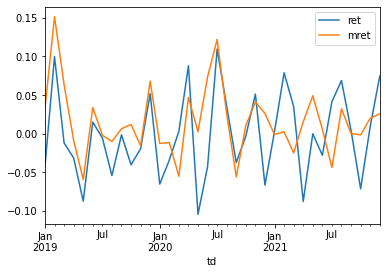

In [38]:
stk = df.loc[df['stkcd'] == "601390.SH"].set_index('td').copy()
# 300750.SZ 宁德时代
# 002594.SZ 比亚迪
# 002714.SZ 牧原股份
# 000001.SZ 平安银行
# 000002.SZ 万科
# 601390.SH 中国中铁
stk.dropna(inplace=True)
stk[['ret', 'mret']].plot()

In [ ]:
pandas

<AxesSubplot:xlabel='td'>

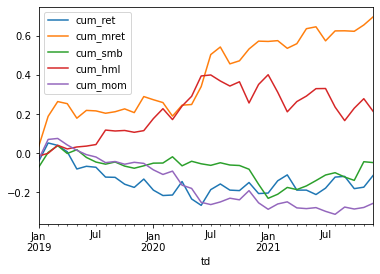

In [39]:
stk['cum_ret'] = (stk['ret'] + 1).cumprod() - 1
stk['cum_mret'] = (stk['mret'] + 1).cumprod() - 1
stk['cum_smb'] = (stk['smb'] + 1).cumprod() - 1
stk['cum_hml'] = (stk['hml'] + 1).cumprod() - 1
stk['cum_mom'] = (stk['mom'] + 1).cumprod() - 1
stk[['cum_ret', 'cum_mret', 'cum_smb', 'cum_hml', 'cum_mom']].plot()

In [40]:
stk.tail()
# A股指数
# 2019年1月：3141
# 2021年12月16日：4871
# 涨幅：55%
# 计算结果：70%

# 平安银行
# 2019年1月: 9.75
# 2021年12月16日: 17.72
# 涨幅: 82%
# 计算结果: 96%

,stkcd,prc,ym,ret,ret_l12_l2,pb_l1,retw,size_rank,pb_rank,sl,sn,sh,bl,bn,bh,ret_rank,cnt,mret,smb,hml,mom,cum_ret,cum_mret,cum_smb,cum_hml,cum_mom
td,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-31,601390.SH,6.99,202108,0.068807,0.068471,0.6167,0.068807,0.977566,0.016240,False,False,False,False,False,False,0.426006,4453,0.032294,0.013230,-0.071413,-0.021603,-0.121859,0.625794,-0.099391,0.236133,-0.312218
2021-09-30,601390.SH,7.02,202109,0.004292,-0.012232,0.6427,0.004292,0.977987,0.015210,False,False,False,False,False,False,0.401344,4492,0.000340,-0.024577,-0.055893,0.053930,-0.118090,0.626347,-0.121525,0.167042,-0.275127
2021-10-31,601390.SH,6.52,202110,-0.071225,-0.078684,0.6461,-0.071225,0.978624,0.013839,False,False,False,False,False,False,0.391788,4523,-0.001535,-0.019427,0.054316,-0.013787,-0.180905,0.623851,-0.138591,0.230431,-0.285120
2021-11-30,601390.SH,6.58,202111,0.009202,-0.035613,0.5993,0.009202,0.977222,0.013414,False,False,False,False,False,False,0.393798,4555,0.019872,0.110702,0.039562,0.011111,-0.173367,0.656120,-0.043232,0.279109,-0.277177
2021-12-31,601390.SH,7.07,202112,0.074468,-0.030675,0.5860,0.074468,0.977168,0.011992,False,False,False,False,False,False,0.410736,4577,0.025738,-0.004676,-0.051889,0.030140,-0.111809,0.698746,-0.047706,0.212737,-0.255391


$$
r_i - r_f = \alpha + \beta_1 (r_M - r_f) + \beta_2 SMB + \beta_3 HML + \beta_4 Momentum
$$

In [42]:
stk['ret'] -= rf
stk['mret'] -= rf

X1 = stk[['mret']].values 
X3 = stk[['mret', 'smb', 'hml']].values
X4 = stk[['mret', 'smb', 'hml', 'mom']].values
y = stk['ret'].values

print('CAPM')
reg = LinearRegression().fit(X1, y)
reg.score(X1, y)  # 拟合优度
# reg.coef_  # Beta
# reg.intercept_  # Alpha

print('FF3')
reg = LinearRegression().fit(X3, y)
reg.score(X3, y)  # 拟合优度
# reg.coef_  # Beta
# reg.intercept_  # Alpha

print('FF3+Mom')
reg = LinearRegression().fit(X4, y)
reg.score(X4, y)  # 拟合优度
# reg.coef_  # Beta
# reg.intercept_  # Alpha

CAPM


0.24453629083655481

FF3


0.5984692535942834

FF3+Mom


0.6079705710011718